In [1]:
from os.path import join
import json
import csv
import glob
import os

import rpy2.rinterface
from pandas import read_csv, DataFrame, Series
from qiime2 import Artifact
from statsmodels.stats.weightstats import DescrStatsW
from scipy.stats import t, sem
from IPython.display import Image

In [33]:
%reload_ext rpy2.ipython

In [34]:
%%R 
library(ggplot2)
library(grid)

In [35]:
empo3_dir = '/home/ben/Data/treepop/'

In [36]:
columns = ['sample type', 'sample', 'fold']
data = {c:[] for c in columns}
for type_dir in glob.glob(join(empo3_dir, '*')):
    if not os.path.exists(join(type_dir, 'results', 'shannon.json')):
        continue
    type_ = os.path.basename(type_dir)
    if type_ in ('sterile-water-blank', 'single-strain', 'mock-community', 'nick', 'plant-surface'):
        continue
    for fold_dir in glob.glob(join(type_dir, 'tmp', 'fold-*')):
        _, fold = fold_dir.rsplit('-', 1)
        with open(join(fold_dir, 'sample_test.json')) as fh:
            try:
                samples = json.load(fh)
            except UnicodeDecodeError:
                print(join(fold_dir, 'sample_test.json'), 'is corrupted')
        data['sample'].extend(samples)
        data['sample type'].extend([type_]*len(samples))
        data['fold'].extend([fold]*len(samples))
folds = DataFrame(data)

In [37]:
folds.head()

,sample type,sample,fold
0,animal-distal-gut,10422.36.F.5.35074,3
1,animal-distal-gut,894.OS1266.lane5.NoIndex.L005.30696,3
2,animal-distal-gut,10323.P51Y69.0612B.30841,3
3,animal-distal-gut,894.UY86.lane3.NoIndex.L003.30696,3
4,animal-distal-gut,550.L1S343.s.1.sequence.30395,3


In [38]:
abundances = read_csv(join(empo3_dir, 'abundances.tsv'), sep='\t')
abundances = abundances.set_index(['sample type', 'sample'])

In [39]:
prf = read_csv(join(empo3_dir, 'eval_taxa_prf.tsv'), sep='\t')

In [40]:
prf = prf.join(abundances, ['sample type', 'sample'])

In [41]:
folds = folds.set_index(['sample type', 'sample'])
prf = prf.join(folds, ['sample type', 'sample'])

In [42]:
prf = prf[prf['method'] == 'weighted']
level7 = prf[(prf['level'] == 7) | (prf['level'] == 6)]

In [43]:
level7.head()

,Unnamed: 0,F-measure,Precision,Recall,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,Unnamed: 0.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1,...,Unnamed: 0.1.1.1.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1.1,class weights,level,method,sample,sample type,abundance,fold
5,5,0.429641,0.974187,0.275592,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,Model4-0.95,6,weighted,894.UY45.lane3.NoIndex.L003.30696,animal-distal-gut,7395,3
6,6,0.173572,0.927916,0.095740,6.0,6.0,6.0,6.0,6.0,6.0,...,6.0,6.0,6.0,Model4-0.95,7,weighted,894.UY45.lane3.NoIndex.L003.30696,animal-distal-gut,7395,3
19,19,0.647033,0.955534,0.489118,19.0,19.0,19.0,19.0,19.0,19.0,...,19.0,19.0,5.0,Model4-0.95,6,weighted,10323.B46G19.F.1011A.30841,animal-distal-gut,12038,1
20,20,0.579780,0.943269,0.418508,20.0,20.0,20.0,20.0,20.0,20.0,...,20.0,20.0,6.0,Model4-0.95,7,weighted,10323.B46G19.F.1011A.30841,animal-distal-gut,12038,1
33,33,0.633511,0.986872,0.466482,33.0,33.0,33.0,33.0,33.0,33.0,...,33.0,33.0,5.0,Model4-0.95,6,weighted,894.OS1694.lane5.NoIndex.L005.30696,animal-distal-gut,12247,0


In [44]:
grouped = level7.groupby(['sample type', 'class weights', 'fold', 'level'])
def weighted_stats(x):
    d1 = DescrStatsW(x['F-measure'], weights=x['abundance'])
    return Series([d1.mean], index=['mean'])
figure1 = grouped.apply(weighted_stats)
figure1.reset_index(inplace=True)

In [45]:
old_labels = [
    'animal-corpus',
    'animal-distal-gut',
    'animal-proximal-gut',
    'animal-secretion',
    'animal-surface',
    'plant-corpus',
    'plant-rhizosphere',
    'sediment-non-saline',
    'soil-non-saline',
    'surface-non-saline',
    'water-non-saline',
    'sediment-saline',
    'surface-saline',
    'water-saline',
    'average', 'uniform70', 'bespoke70']
new_labels = [
    'Other'] * 14 + ['Average', 'Uniform', 'Bespoke']
for old, new in zip(old_labels, new_labels):
    figure1.loc[figure1['class weights'] == old, 'class weights'] = new
old_labels = [
    'animal-corpus',
    'animal-distal-gut',
    'animal-proximal-gut',
    'animal-secretion',
    'animal-surface',
    'plant-corpus',
    'plant-rhizosphere',
    'sediment-non-saline',
    'soil-non-saline',
    'surface-non-saline',
    'water-non-saline',
    'sediment-saline',
    'surface-saline',
    'water-saline'
]
new_labels = [
    'Animal corpus',
    'Animal distal gut',
    'Animal proximal gut',
    'Animal secretion',
    'Animal surface',
    'Plant corpus',
    'Plant rhizosphere',
    'Sediment (non-saline)',
    'Soil (non-saline)',
    'Surface (non-saline)',
    'Water (non-saline)',
    'Sediment (saline)',
    'Surface (saline)',
    'Water (saline)'
]
for old, new in zip(old_labels, new_labels):
    figure1.loc[figure1['sample type'] == old, 'sample type'] = new
for old, new in zip((6, 7), ('Genus', 'Species')):
    figure1.loc[figure1['level'] == old, 'level'] = new

In [46]:
figure1 = figure1[figure1['level'] == 'Species']

In [47]:
figure1.head()

,sample type,class weights,fold,level,mean
1,Animal distal gut,Ben11,0,Species,0.825882
3,Animal distal gut,Ben11,1,Species,0.836413
5,Animal distal gut,Ben11,2,Species,0.843050
7,Animal distal gut,Ben11,3,Species,0.826749
9,Animal distal gut,Ben11,4,Species,0.840012


In [48]:
%%R -i figure1
p <- ggplot(data=figure1, aes(x=class.weights, y=mean)) +
  geom_boxplot(lwd=0.2, outlier.size=0.2, position=position_dodge(width=0.9)) +
  coord_flip(clip="off") + 
  theme_bw() +
  labs(x='Model', y='F-measure') +
  theme(plot.margin = unit(c(1, 1, 2, 1), "lines"),
        axis.text.y = element_text(angle = 45)) 

ggsave(file="f-measure-vs-model.png", width=5, height=10, dpi=300)

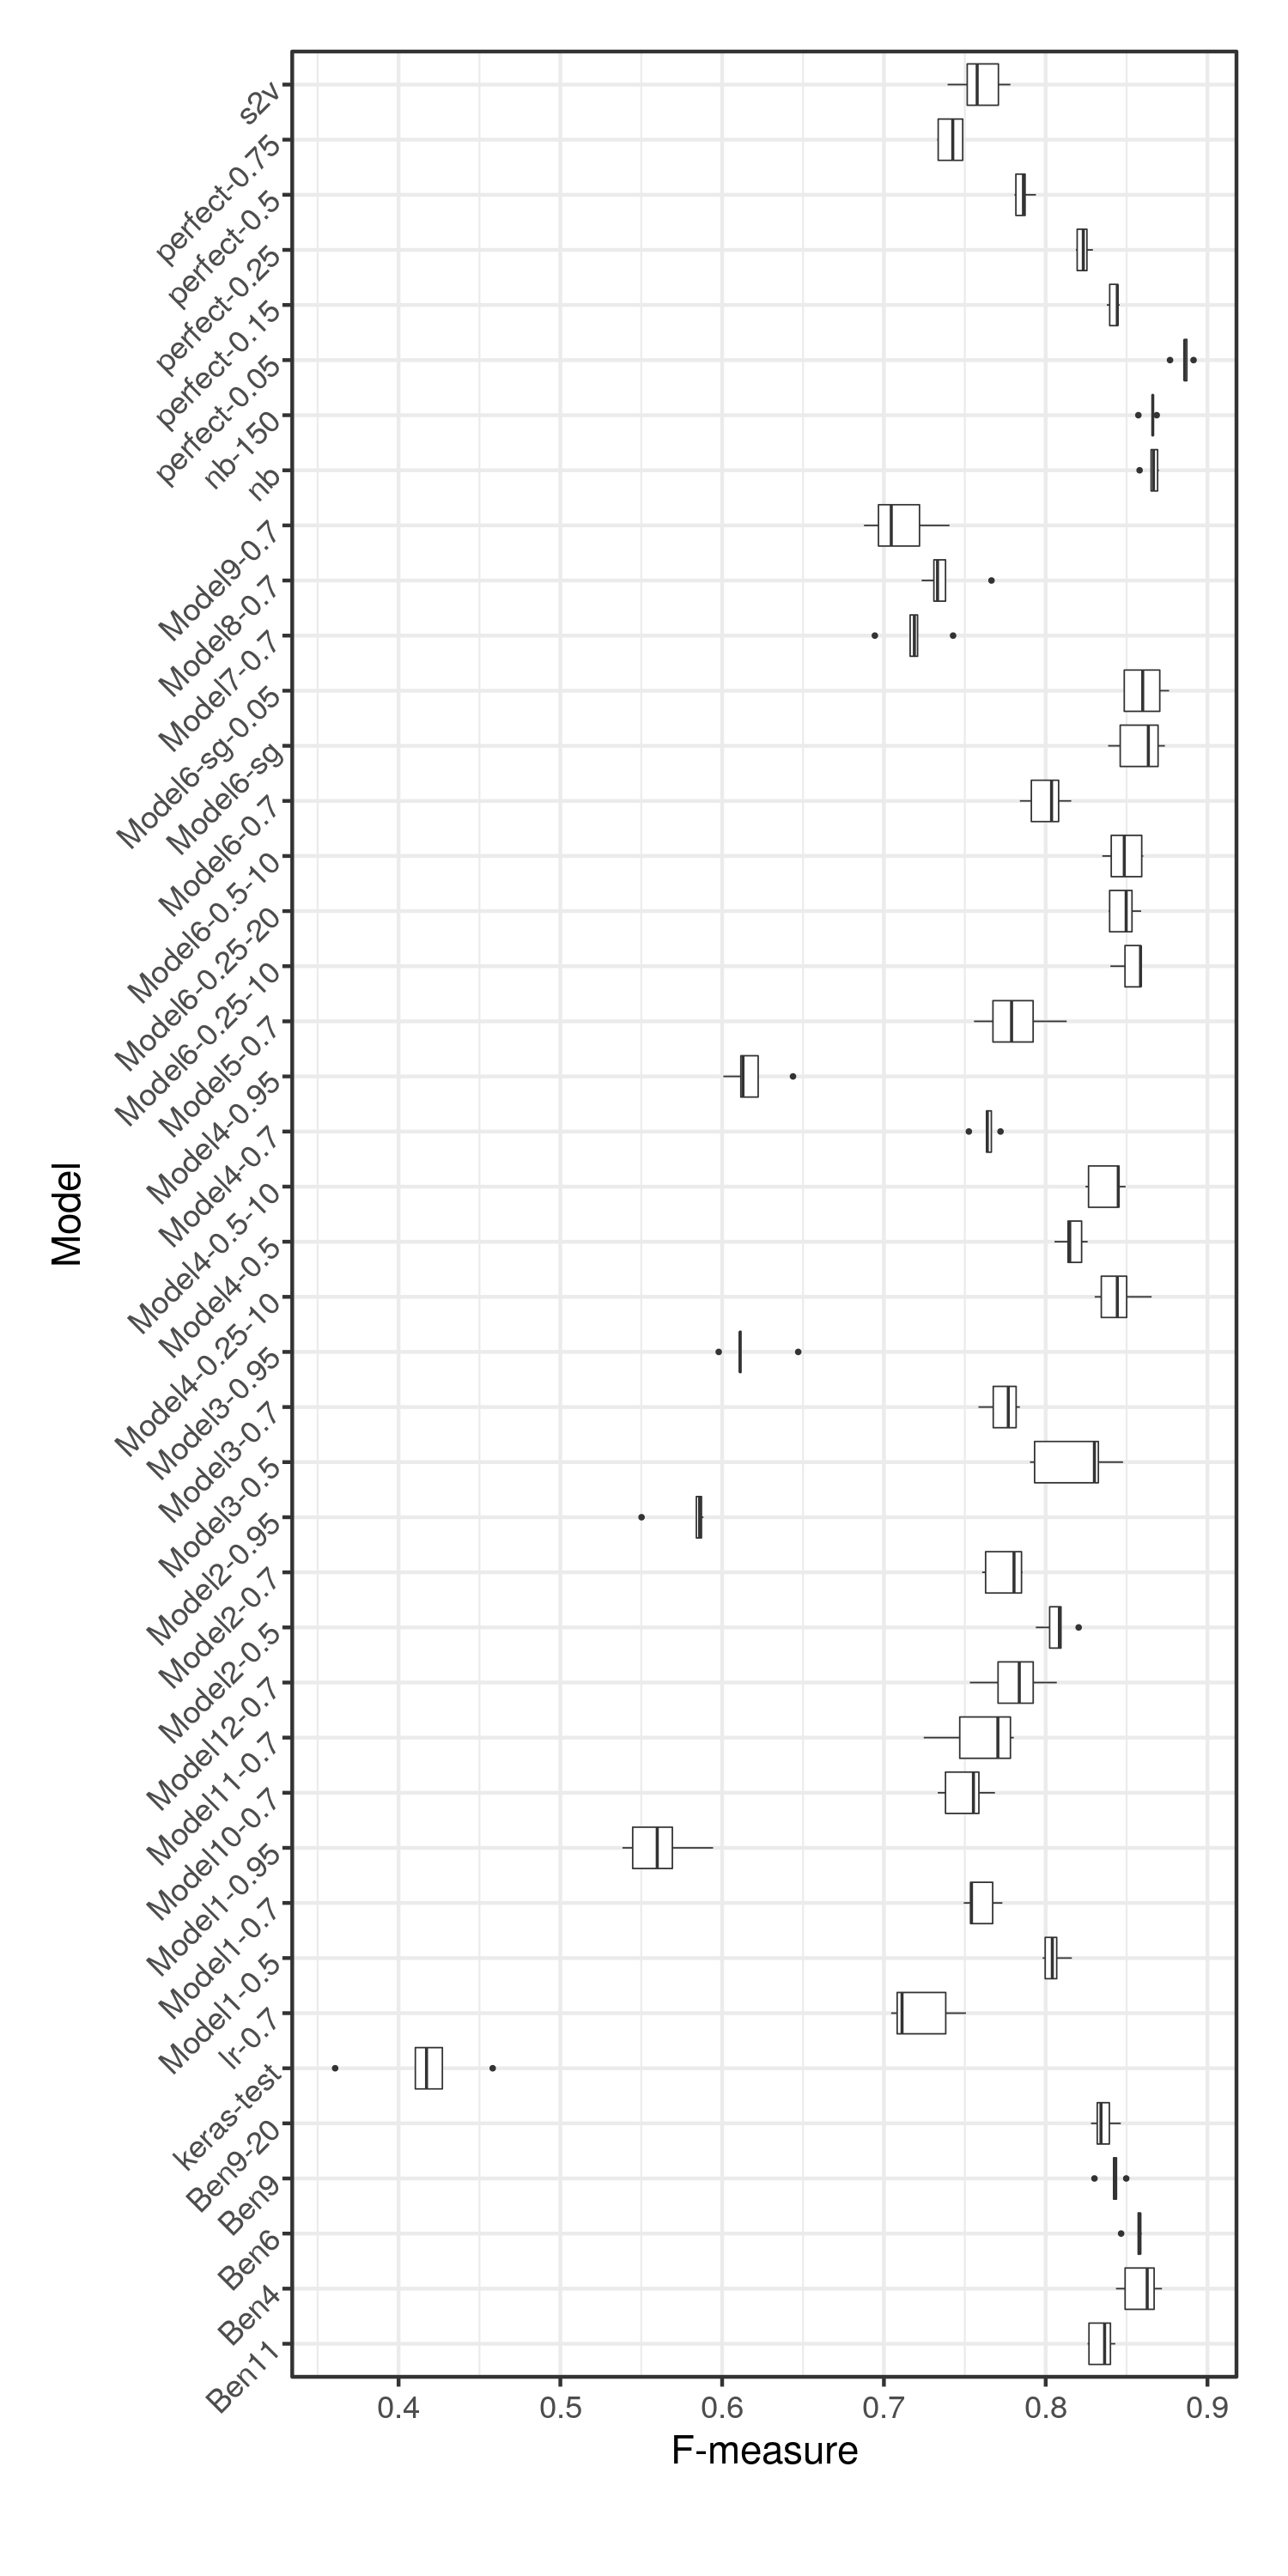

In [49]:
Image("f-measure-vs-model.png")

In [16]:
max(figure1['upper'] - figure1['lower'])

0.13128721225598428

In [17]:
bespoke = figure1[figure1['class weights'] == 'Bespoke']['mean']
print(min(bespoke), max(bespoke))
uniform = figure1[figure1['class weights'] == 'Uniform']['mean']
print(min(uniform), max(uniform))

0.8288638081095409 0.9305880832502146
0.720229783917639 0.9021711163046009


In [18]:
len(set(level7['sample']))

21513

In [19]:
list(set(level7['sample']))[:10]

['11113.907.36782',
 '2192.H01a.Bedroom.Floor.268.lane2.NoIndex.L002.30619',
 '550.L6S38.s.6.sequence.30395',
 '550.L4S155.s.4.sequence.30395',
 '11113.686.36782',
 '11444.H4.fecal.none.1wk.43342',
 '10308.Fh.P4.IFF.B.10.30930',
 '1883.2005.21.Crump.Artic.LTREB.main.lane4.NoIndex.30612',
 '1024.SH004.C1.RH.1.161.flw.6.11.G1.L00.28362',
 '550.L4S165.s.4.sequence.30395']

In [20]:
len(set(_id.split('.')[1] for _id in level7['sample']))

7204

In [21]:
len(set(_id.split('.')[1] for _id in level7[level7['sample type']=='surface-saline']['sample']))

58

In [35]:
grouped = level7.groupby(['sample type', 'class weights', 'fold'])
def weighted_stats(x):
    d1 = DescrStatsW(x['Recall'], weights=x['abundance'])
    return Series([d1.mean], index=['mean'])
precision = grouped.apply(weighted_stats)
precision.reset_index(inplace=True)
grouped = precision.groupby(['sample type', 'class weights'])
def weighted_stats(x):
    mu = x['mean'].mean()
    se = sem(x['mean'])
    lower, upper = t.interval(0.95, 5, mu, se)
    return Series([mu, lower, upper], index=['mean', 'lower', 'upper'])
precision = grouped.apply(weighted_stats)
precision.reset_index(inplace=True)
precision[(precision['class weights'] == 'bespoke70') | 
          (precision['class weights'] == 'uniform70')]

,sample type,class weights,mean,lower,upper
5,animal-corpus,bespoke70,0.834079,0.807420,0.860737
13,animal-corpus,uniform70,0.696828,0.671568,0.722089
21,animal-distal-gut,bespoke70,0.836902,0.830967,0.842838
29,animal-distal-gut,uniform70,0.761069,0.746696,0.775442
37,animal-proximal-gut,bespoke70,0.787296,0.752892,0.821699
45,animal-proximal-gut,uniform70,0.650310,0.628537,0.672082
53,animal-secretion,bespoke70,0.854664,0.851688,0.857641
61,animal-secretion,uniform70,0.639334,0.629122,0.649546
69,animal-surface,bespoke70,0.838421,0.831812,0.845030
77,animal-surface,uniform70,0.669983,0.647305,0.692661
